<a href="https://colab.research.google.com/github/ialimustufa/intel/blob/main/Part3_Model_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Analysis of InceptionV3 Training on CPU

Copyright (c) 2019 Intel Corporation.

Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files (the
"Software"), to deal in the Software without restriction, including
without limitation the rights to use, copy, modify, merge, publish,
distribute, sublicense, and/or sell copies of the Software, and to
permit persons to whom the Software is furnished to do so, subject to
the following conditions:

The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF
MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE
LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION
OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION
WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


# Objective 
Understand how we can interpret the results of our training by analyzing out model with different metrics and graphs.

# Activities 
**In this section of the training you will**
- Load your trained model
- Load your test dataset
- Gather prediction values on your test set
- Understand a confusion matrix
- Understand a classification report
- Understand precision, f1, recall, roc

We're going to start by loading in our model from training that contains training on all of our layers.  Since we saved in the hdf5 format it means we'll see the entire structure of the model  and won't have to reinstaniate it before using it.

Click the cell below and then click **Run**.

In [ ]:
!wget https://storage.googleapis.com/datasetsbyali/intel_weights/top_layers.iv3.hdf5 #Model from Notebook part 2

--2021-02-13 09:13:32--  https://storage.googleapis.com/datasetsbyali/intel_weights/top_layers.iv3.hdf5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.101.128, 2607:f8b0:4023:c03::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113377856 (108M) [application/octet-stream]
Saving to: ‘top_layers.iv3.hdf5’

top_layers.iv3.hdf5 100%[===================>] 108.12M  84.1MB/s    in 1.3s    

2021-02-13 09:13:33 (84.1 MB/s) - ‘top_layers.iv3.hdf5’ saved [113377856/113377856]



In [ ]:
from keras.models import load_model
model = load_model('top_layers.iv3.hdf5')

As in the training we can utilize a data generator to pass our test data set easily by just pointing at a directory.  We'll pass in the test data set directory, set the target size to 299x299 and add a batch size of 32.  One important thing to note is that need for setting shuffle to False, since when we analysis our data at the end we prefer to have it in order since we can easily pass it into our evaluation and graphing functions.

Click the cell below and then click **Run**.

In [ ]:
!wget https://storage.googleapis.com/datasetsbyali/intel_weights/test.zip #Test Data made from 

--2021-02-13 09:13:52--  https://storage.googleapis.com/datasetsbyali/intel_weights/test.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.128, 74.125.137.128, 2607:f8b0:4023:c03::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51578736 (49M) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[===================>]  49.19M   110MB/s    in 0.4s    

2021-02-13 09:13:53 (110 MB/s) - ‘test.zip’ saved [51578736/51578736]



In [ ]:
!unzip test.zip

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
#Test DataSet Generator with Augmentation
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_flow = test_generator.flow_from_directory(
    '/content/test',
    shuffle=False,
    target_size=(229, 229),
    batch_size = 32
)

Found 1193 images belonging to 10 classes.


Here we use the **predict_generator** and pass in our test data set generator.  This will generate predictions from the input samples of the data generator which we will pass in to our analysis functions.  We also want to get the correct classes from the generator so we'll store them in the variable true_classes for easy access to them later. 

Click the cell below and then click **Run**.

In [ ]:
import math
import numpy as np
predictions = model.predict_generator(
    test_flow,
    verbose=1,
    steps=math.ceil(test_flow.samples/test_flow.batch_size))
predicted_classes = np.argmax(predictions, axis=1) 

true_classes = test_flow.classes
class_labels = list(test_flow.class_indices.keys())  

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


38/38 [==============================] - 78s 2s/step


A common graph to plot for analysis is a confusion matrix.  It will play out the true label vs the predicted label on a graph and color code them accordingly.  The ideal confusion matrix will have a diaganol line from the top left to the bottom right and no other color.  This means that each predicted value matched the true value.  What you'll normally see is that each class might lean toward one or two other classes that might look similar to the true class

### Activity
In the cell below, update the **first variable** to **true_classes** and the **second variables** to **predicted_classes**, and then click **Run**.

In [ ]:
!pip install scikit-plot

0 : chevrolet_impala_2008
1 : chevrolet_silverado_2004
2 : dodge_ram_2001
3 : ford_f150_2006
4 : gmc_sierra_2012
5 : honda_accord_1997
6 : honda_civic_1998
7 : nissan_altima_2014
8 : toyota_camry_2014
9 : toyota_corolla_2013


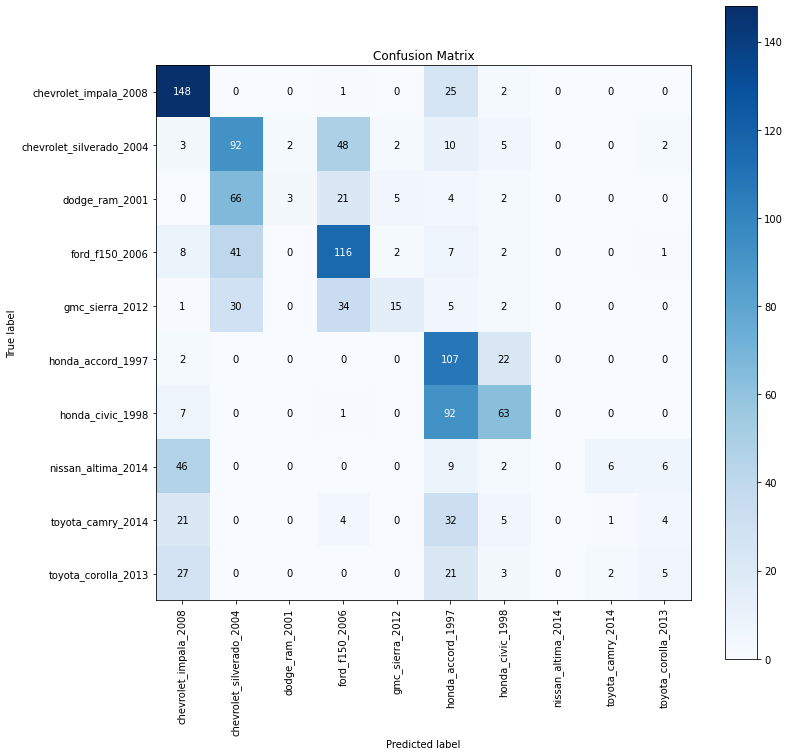

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline  
import scikitplot as skplt

[print(k, ":", v) for k,v in enumerate(class_labels)]
true_map_classes = [class_labels[x] for x in true_classes]
predicted_map_classes = [class_labels[x] for x in predicted_classes]

skplt.metrics.plot_confusion_matrix(
    true_map_classes, 
    predicted_map_classes,
    labels=class_labels,
    x_tick_rotation=90,
    figsize=(12,12))

Next, we'll look at text based version of different main classification metrics.

**Precision**: The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The best value is 1 and the worst value is 0.

**Recall**: The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The best value is 1 and the worst value is 0.

**F1-Score**: Compute the F1 score, also known as balanced F-score or F-measure

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

F1 = 2 * (precision * recall) / (precision + recall)
In the multi-class and multi-label case, this is the average of the F1 score of each class with weighting depending on the average parameter.

**Support**: The total number of classes being used for the evaluation


Click the cell below and then click **Run**.

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(
    true_classes,
    predicted_classes,
    target_names=class_labels)
print(report)

                          precision    recall  f1-score   support

   chevrolet_impala_2008       0.56      0.84      0.67       176
chevrolet_silverado_2004       0.40      0.56      0.47       164
          dodge_ram_2001       0.60      0.03      0.06       101
          ford_f150_2006       0.52      0.66      0.58       177
         gmc_sierra_2012       0.62      0.17      0.27        87
       honda_accord_1997       0.34      0.82      0.48       131
        honda_civic_1998       0.58      0.39      0.46       163
      nissan_altima_2014       0.00      0.00      0.00        69
       toyota_camry_2014       0.11      0.01      0.03        67
     toyota_corolla_2013       0.28      0.09      0.13        58

                accuracy                           0.46      1193
               macro avg       0.40      0.36      0.32      1193
            weighted avg       0.45      0.46      0.40      1193



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Click the cell below and then click **Run**.

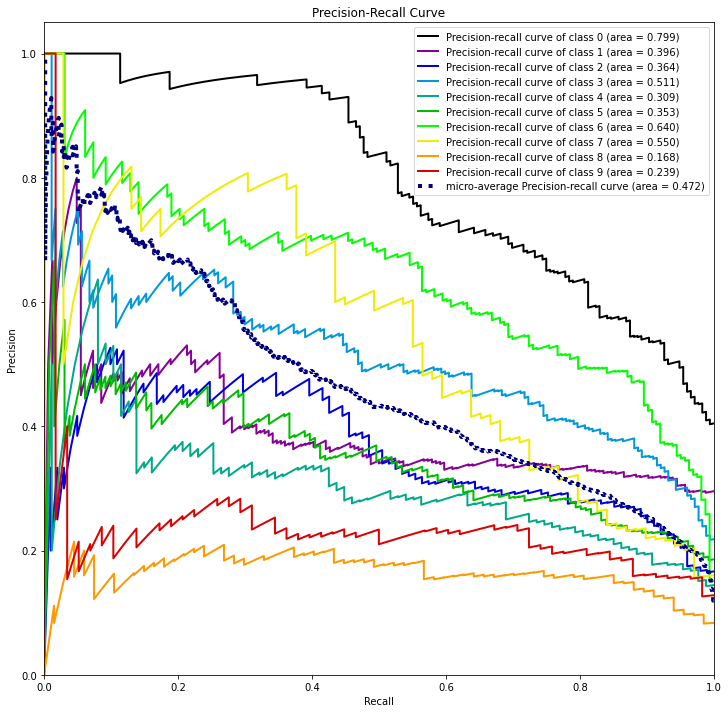

In [ ]:
skplt.metrics.plot_precision_recall(
    true_classes,
    predictions,
    figsize=(12,12))

The function roc_curve computes the receiver operating characteristic curve, or ROC curve. Quoting Wikipedia :

“A receiver operating characteristic (ROC), or simply ROC curve, is a graphical plot which illustrates the performance of a binary classifier system as its discrimination threshold is varied. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate), at various threshold settings. TPR is also known as sensitivity, and FPR is one minus the specificity or true negative rate.”

Click the cell below and then click **Run**.

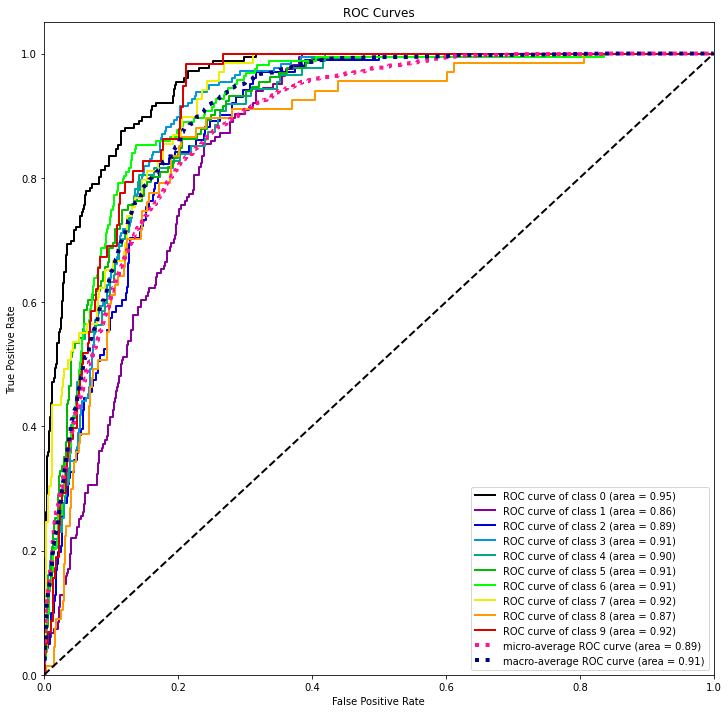

In [ ]:
skplt.metrics.plot_roc(
    true_classes,
    predictions,
    figsize=(12,12))

## Summary
**In this section of the training you learned**

- Load your trained model
- Load your test dataset
- Gather prediction values on your test set
- Understand a confusion matrix
- Understand a classification report
- Understand precision, f1, recall, roc